In [1]:
# load sql extension
%load_ext sql

In [2]:
%sql postgresql://postgres@localhost:5432/online_shop_2024

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Check the orders of a given customer**

In [11]:
%%sql
select column_name, data_type
from information_schema.columns
where table_name='products';

 * postgresql://postgres@localhost:5432/online_shop_2024
5 rows affected.


column_name,data_type
product_id,bigint
price,numeric
supplier_id,bigint
product_name,text
category,text


In [16]:
%%sql
DROP FUNCTION IF EXISTS check_orders;

CREATE OR REPLACE FUNCTION check_orders(id bigint)
RETURNS table(
    customer_id bigint,
    first_name char(32),
    last_name char(32),
    order_id bigint,
    quantity  int,
    price_at_purchase numeric,
    product_name text
) AS $$
BEGIN 
    RETURN QUERY
    SELECT c.customer_id, c.first_name, c.last_name, o.order_id, i.quantity, i.price_at_purchase, p.product_name
    FROM customers c 
    JOIN orders o 
    ON c.customer_id=o.customer_id
    JOIN order_items i
    ON o.order_id=i.order_id
    JOIN products p 
    ON i.product_id=p.product_id
    WHERE c.customer_id=id;
END;
$$ LANGUAGE plpgsql;

 * postgresql://postgres@localhost:5432/online_shop_2024
Done.
Done.


[]

In [27]:
%sql SELECT * FROM check_orders(6);

 * postgresql://postgres@localhost:5432/online_shop_2024
3 rows affected.


customer_id,first_name,last_name,order_id,quantity,price_at_purchase,product_name
6,James,Garcia,12064,1,778.15,USB-C Hub
6,James,Garcia,3767,10,175.45,Smart Watch
6,James,Garcia,3767,2,12.86,Smart Watch


**Which customer has spent the most on online shopping in 2024?**

In [31]:
%%sql 
SELECT c.customer_id, c.first_name, c.last_name, SUM(o.total_price) AS total_spent, COUNT(order_id) as num_orders
FROM customers c
JOIN orders o 
ON c.customer_id=o.customer_id
GROUP BY c.customer_id
ORDER BY total_spent DESC
LIMIT 1;

 * postgresql://postgres@localhost:5432/online_shop_2024
1 rows affected.


customer_id,first_name,last_name,total_spent,num_orders
9803,John,Williams,19651.70,2


**How many products were sold in 2024 for each product category?**

In [33]:
%%sql 
category_num << 
SELECT p.category, SUM(i.quantity) AS total_sold
FROM products p 
JOIN order_items i 
ON p.product_id=i.product_id
GROUP BY p.category;

 * postgresql://postgres@localhost:5432/online_shop_2024
4 rows affected.
Returning data to local variable category_num


[]

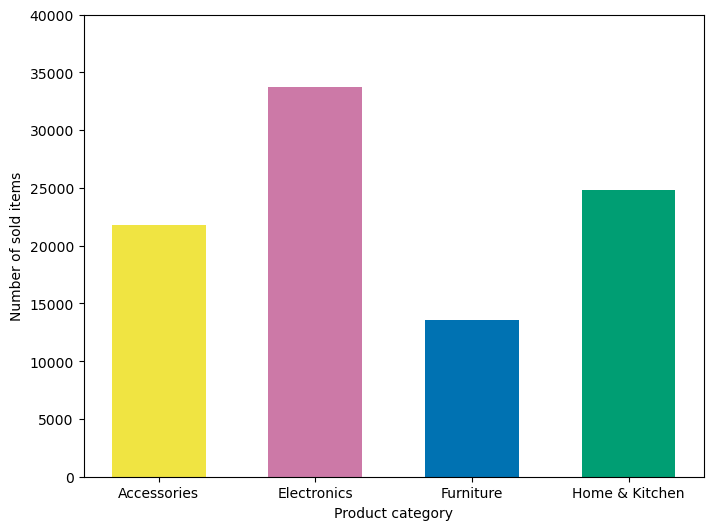

In [38]:
category_num = pd.DataFrame(category_num)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x=category_num['category'], height=category_num['total_sold'], color=['#f0e442', '#cc79a7', '#0072b2', '#009e73'], width=0.6)
ax.set_ylim(0, 40000)
ax.set_ylabel('Number of sold items')
ax.set_xlabel('Product category')
plt.plot()

**What are the total profit of each categroy?**

In [39]:
%%sql 
category_profit << 
SELECT p.category, SUM(o.total_price) AS total_sold
FROM products p 
JOIN order_items i 
ON p.product_id=i.product_id
JOIN orders o 
ON i.order_id=o.order_id
GROUP BY p.category;

 * postgresql://postgres@localhost:5432/online_shop_2024
4 rows affected.
Returning data to local variable category_profit


[]

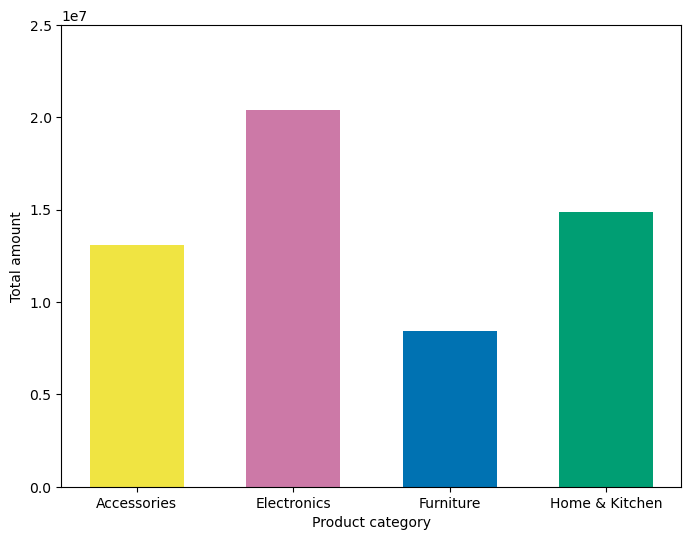

In [42]:
category_profit = pd.DataFrame(category_profit)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x=category_profit['category'], height=category_profit['total_sold'], color=['#f0e442', '#cc79a7', '#0072b2', '#009e73'], width=0.6)
ax.set_ylim(0, 2.5e7)
ax.set_ylabel('Total amount')
ax.set_xlabel('Product category')
plt.plot()

**Which five products are highly rated by the customers in each category?**

In [25]:
%%sql
WITH ranked AS (
    SELECT p.product_id, p.product_name, p.category, ROUND(AVG(r.rating::NUMERIC), 2) AS avg_rating, ROW_NUMBER() OVER(PARTITION BY p.category ORDER BY ROUND(AVG(r.rating::NUMERIC), 2) DESC) AS rank
    FROM products p
    JOIN reviews r
    ON p.product_id=r.product_id
    GROUP BY p.product_id, p.product_name, p.category
) 
SELECT * FROM ranked
WHERE rank <= 5;

 * postgresql://postgres@localhost:5432/online_shop_2024
20 rows affected.


product_id,product_name,category,avg_rating,rank
19,Laptop Sleeve,Accessories,5.00,1
1519,Laptop Sleeve,Accessories,5.00,2
13,Phone Grip,Accessories,5.00,3
1544,Screen Protector,Accessories,5.00,4
1524,Portable Charger,Accessories,5.00,5
1575,Bluetooth Headphones,Electronics,5.00,1
1553,Document Scanner,Electronics,5.00,2
75,Bluetooth Headphones,Electronics,5.00,3
27,Smart Watch,Electronics,5.00,4
71,Power Strip,Electronics,5.00,5


**The number of products provided by each individual supplier**

In [43]:
%%sql
num_products_by_supplier <<
SELECT s.supplier_id, s.supplier_name, p.category, COUNT(p.product_id)
FROM suppliers s 
JOIN products p 
ON s.supplier_id=p.supplier_id
GROUP BY s.supplier_id, p.category
ORDER BY s.supplier_id;

 * postgresql://postgres@localhost:5432/online_shop_2024
100 rows affected.
Returning data to local variable num_products_by_supplier


In [44]:
num_products_by_supplier = pd.DataFrame(num_products_by_supplier)
num_products_by_supplier.head()

,supplier_id,supplier_name,category,count
0,501,Dynamic Systems Group,Furniture,20
1,502,Dynamic Systems Group,Home & Kitchen,20
2,503,Mega Suppliers,Electronics,20
3,504,Tech Supplies Inc.,Accessories,20
4,505,Ultimate Services,Accessories,20


**Which five suppliers have the highest revenue in 2024?**

In [ ]:
%%sql
-- DROP VIEW join_suppliers_products_items; 

CREATE VIEW join_suppliers_products_items AS (
    SELECT
        (ROW(s.*))::suppliers   AS supplier,
        (ROW(p.*))::products    AS product,
        (ROW(i.*))::order_items AS order_item
    FROM suppliers s
    JOIN products p ON p.supplier_id = s.supplier_id
    JOIN order_items i ON i.product_id = p.product_id
);

 * postgresql://postgres@localhost:5432/online_shop_2024
Done.
Done.


[]

In [5]:
%%sql 
SELECT 
    (supplier).supplier_id,
    (supplier).supplier_name,
    SUM((order_item).quantity*(order_item).price_at_purchase) AS yearly_revenue
FROM join_suppliers_products_items
GROUP BY (supplier).supplier_id, (supplier).supplier_name
ORDER BY yearly_revenue DESC
LIMIT 5;

 * postgresql://postgres@localhost:5432/online_shop_2024
5 rows affected.


supplier_id,supplier_name,yearly_revenue
572,Next Level Systems,550549.88
597,Precision Suppliers LLC,529583.74
546,Ultimate Services,515871.40
596,Unified Trading Co.,512795.10
586,Excel Distribution Group,512761.33


**Which five suppliers have the highest profit in 2024?**

In [6]:
%%sql 

SELECT 
    (supplier).supplier_id,
    (supplier).supplier_name,
    SUM((order_item).quantity*((order_item).price_at_purchase-(product).price)) AS yearly_revenue
FROM join_suppliers_products_items
GROUP BY (supplier).supplier_id, (supplier).supplier_name
ORDER BY yearly_revenue DESC
LIMIT 5;


 * postgresql://postgres@localhost:5432/online_shop_2024
5 rows affected.


supplier_id,supplier_name,yearly_revenue
540,Premier Logistics Inc.,86217.08
530,Tech Supplies Inc.,82769.23
551,Dynamic Systems Group,66127.99
565,Advanced Hardware Corp.,62293.62
539,Professional Supply Chain,47891.95


**Which carrier is the most efficient one?**

In [12]:
%%sql
SELECT carrier, ROUND(AVG(EXTRACT(day FROM AGE(delivery_date, shipment_date))), 2) AS avg_delivery_days
FROM shipments
WHERE shipment_status='Delivered'
GROUP BY carrier;

 * postgresql://postgres@localhost:5432/online_shop_2024
3 rows affected.


carrier,avg_delivery_days
DHL,4.50
FedEx,4.55
UPS,4.48


**Check the shipment information for a given order**

In [22]:
%%sql
DROP FUNCTION IF EXISTS check_shipment;

CREATE OR REPLACE FUNCTION check_shipment(order_num bigint)
RETURNS TABLE (
    order_id bigint,
    product_name text,
    carrier varchar(32),
    tracking_number text,
    shipment_date date,
    shipment_status text
) AS $$
BEGIN 
    RETURN QUERY
    SELECT s.order_id, p.product_name, s.carrier, s.tracking_number, s.shipment_date, s.shipment_status
    FROM shipments s
    JOIN orders o 
    ON s.order_id=o.order_id
    JOIN order_items i 
    ON o.order_id=i.order_id
    JOIN products p 
    ON i.product_id=p.product_id
    WHERE s.order_id=order_num;
END;
$$ LANGUAGE plpgsql;

 * postgresql://postgres@localhost:5432/online_shop_2024
Done.
Done.


[]

In [25]:
%%sql 
SELECT * FROM check_shipment(3);

 * postgresql://postgres@localhost:5432/online_shop_2024
1 rows affected.


order_id,product_name,carrier,tracking_number,shipment_date,shipment_status
3,Electric Kettle,FedEx,TRK161368,2024-05-23,Pending


**Which five customers have spent the most money on online shopping in 2024?**

In [27]:
%%sql
SELECT c.customer_id, c.first_name, c.last_name, SUM(o.total_price) AS total_spent
FROM customers c 
JOIN orders o 
ON c.customer_id=o.customer_id
GROUP BY c.customer_id
ORDER BY total_spent DESC
LIMIT 5;

 * postgresql://postgres@localhost:5432/online_shop_2024
5 rows affected.


customer_id,first_name,last_name,total_spent
9803,John,Williams,19651.70
4114,James,Natalie,17567.00
8941,John,Philip,17124.03
9953,John,Gonzalez,16956.25
7387,Mary,Douglas,16952.30


**Which five customers tend to give the lowest ratings?**

In [35]:
%%sql
WITH ranked AS (
    SELECT c.customer_id, c.first_name, c.last_name, p.category, ROUND(AVG(r.rating),2) AS avg_rating, ROW_NUMBER () OVER(PARTITION BY p.category ORDER BY ROUND(AVG(r.rating),2)) AS rank
    FROM customers c 
    JOIN reviews r 
    ON c.customer_id=r.customer_id
    JOIN products p 
    ON r.product_id=p.product_id
    GROUP BY c.customer_id, p.category
)
SELECT * FROM ranked
WHERE rank <= 5;

 * postgresql://postgres@localhost:5432/online_shop_2024
20 rows affected.


customer_id,first_name,last_name,category,avg_rating,rank
4504,Mary,Julia,Accessories,1.00,1
6078,Mary,Madison,Accessories,1.00,2
4,James,Brown,Accessories,1.00,3
4505,Mary,Scott,Accessories,1.00,4
1528,James,Madison,Accessories,1.00,5
6060,Mary,Nicole,Electronics,1.00,1
9025,John,Terry,Electronics,1.00,2
7503,Mary,Gonzalez,Electronics,1.00,3
9049,John,Jackson,Electronics,1.00,4
4526,Mary,Sophia,Electronics,1.00,5
